In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
metadata = pd.read_csv('input/rsna-breast-cancer-detection/vindr_mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/metadata.csv')
breast_anno = pd.read_csv('input/rsna-breast-cancer-detection/vindr_mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/breast-level_annotations.csv')
finding_anno = pd.read_csv('input/rsna-breast-cancer-detection/vindr_mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/finding_annotations.csv')

In [4]:
breast_anno.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training


In [5]:
metadata['Manufacturer'].value_counts()

SIEMENS              15244
Planmed               3796
IMS s.r.l.             736
IMS GIOTTO S.p.A.      224
Name: Manufacturer, dtype: int64

In [6]:
metadata['Manufacturer\'s Model Name'].value_counts()

Mammomat Inspiration    15244
Planmed Nuance           3796
GIOTTO CLASS              628
GIOTTO IMAGE 3DL          332
Name: Manufacturer's Model Name, dtype: int64

In [7]:
breast_anno['breast_birads'].value_counts()

BI-RADS 1    13406
BI-RADS 2     4676
BI-RADS 3      930
BI-RADS 4      762
BI-RADS 5      226
Name: breast_birads, dtype: int64

In [8]:
breast_anno['breast_density'].value_counts()

DENSITY C    15292
DENSITY D     2700
DENSITY B     1908
DENSITY A      100
Name: breast_density, dtype: int64

In [9]:
metadata2 = metadata.rename(
    {'SOP Instance UID.1': 'image_id', 'Patient\'s Age': 'age' , 'Manufacturer\'s Model Name': 'machine_id'}, 
    axis=1)[['image_id', 'age', 'machine_id']]
metadata2['age'] = metadata2['age'].str[:-1].astype(float)
metadata2.head()

,image_id,age,machine_id
0,d8125545210c08e1b1793a5af6458ee2,53.0,Mammomat Inspiration
1,290c658f4e75a3f83ec78a847414297c,53.0,Mammomat Inspiration
2,cd0fc7bc53ac632a11643ac4cc91002a,53.0,Mammomat Inspiration
3,71638b1e853799f227492bfb08a01491,53.0,Mammomat Inspiration
4,dd9ce3288c0773e006a294188aadba8e,42.0,Mammomat Inspiration


In [10]:
breast_anno2 = breast_anno.rename({
    'study_id': 'patient_id', 'view_position': 'view', 'breast_birads': 'BIRADS', 'breast_density': 'density', 'split': 'is_test'
}, axis=1)[['patient_id', 'image_id', 'view', 'laterality', 'view', 'BIRADS', 'density', 'is_test']]
breast_anno2['BIRADS'] = breast_anno2['BIRADS'].str[-1].astype(int)
breast_anno2['density'] = breast_anno2['density'].str[-1]
breast_anno2['is_test'] = (breast_anno2['is_test'] == 'test').astype(int)
breast_anno2.head()

,patient_id,image_id,view,laterality,view,BIRADS,density,is_test
0,b8d273e8601f348d3664778dae0e7e0b,d8125545210c08e1b1793a5af6458ee2,CC,L,CC,2,C,0
1,b8d273e8601f348d3664778dae0e7e0b,290c658f4e75a3f83ec78a847414297c,MLO,L,MLO,2,C,0
2,b8d273e8601f348d3664778dae0e7e0b,cd0fc7bc53ac632a11643ac4cc91002a,CC,R,CC,2,C,0
3,b8d273e8601f348d3664778dae0e7e0b,71638b1e853799f227492bfb08a01491,MLO,R,MLO,2,C,0
4,8269f5971eaca3e5d3772d1796e6bd7a,dd9ce3288c0773e006a294188aadba8e,CC,L,CC,1,C,0


In [64]:
finding_anno2 = finding_anno.rename({
    'study_id': 'patient_id', 'view_position': 'view',
}, axis=1).drop(['patient_id', 'series_id'], axis=1)
finding_anno2.head()

,image_id,laterality,view,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
2,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training
3,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training
4,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training


In [57]:
train = metadata2.merge(breast_anno2, on=['image_id'], how='inner')
train.to_csv('input/rsna-breast-cancer-detection/vindr_train.csv', index=False)

In [66]:
finding_anno2.merge(breast_anno2[['image_id', 'patient_id']], on='image_id', how='inner').to_csv('input/rsna-breast-cancer-detection/vindr_findings.csv', index=False)

# Vindr

In [5]:
train_vindr = pd.read_csv('input/rsna-breast-cancer-detection/vindr_train.csv')
train = pd.read_csv(b'input/rsna-breast-cancer-detection/train.csv')

In [4]:
train_vindr['BIRADS'].value_counts()

1    13406
2     4676
3      930
4      762
5      226
Name: BIRADS, dtype: int64

In [5]:
train_vindr['cancer'] = (train_vindr['BIRADS'] >= 4).astype(int)

In [7]:
train_vindr.to_csv('input/rsna-breast-cancer-detection/vindr_train.csv', index=False)

In [11]:
train_vindr.query('BIRADS.isin([1, 5])').to_csv('input/rsna-breast-cancer-detection/vindr_train_birads05.csv', index=False)

In [19]:
pd.concat([train, train_vindr.query('BIRADS.isin([1, 5])')]).drop(['view.1', 'is_test'], axis=1).to_csv(
    'input/rsna-breast-cancer-detection/train_concat_vindr_birads05.csv', index=False)

In [20]:
pd.concat([train, train_vindr.query('BIRADS.isin([1, 5])')]).drop(['view.1', 'is_test'], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68338 entries, 0 to 19994
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  float64
 1   patient_id               68338 non-null  object 
 2   image_id                 68338 non-null  object 
 3   laterality               68338 non-null  object 
 4   view                     68338 non-null  object 
 5   age                      66797 non-null  float64
 6   cancer                   68338 non-null  int64  
 7   biopsy                   54706 non-null  float64
 8   invasive                 54706 non-null  float64
 9   BIRADS                   39918 non-null  float64
 10  implant                  54706 non-null  float64
 11  density                  43102 non-null  object 
 12  machine_id               68338 non-null  object 
 13  difficult_negative_case  54706 non-null  object 
dtypes: float64(6), int64(1

In [5]:
train_findings = pd.read_csv('input/rsna-breast-cancer-detection/vindr_findings.csv')

In [13]:
train_findings['finding_birads'].value_counts()

BI-RADS 4    995
BI-RADS 3    893
BI-RADS 5    241
Name: finding_birads, dtype: int64

In [14]:
train_findings

,image_id,laterality,view,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,patient_id
0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,48575a27b7c992427041a82fa750d3fa
1,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,48575a27b7c992427041a82fa750d3fa
2,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training,75e8e48933289d70b407379a564f8594
3,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training,75e8e48933289d70b407379a564f8594
4,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training,c3487424fee1bdd4515b72dc3fd69813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20481,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,f2093a752e6b44df5990f5fd38c99dd2
20482,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,b3c8969cd2accfa4dbb2aece1f7158ab
20483,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,b3c8969cd2accfa4dbb2aece1f7158ab
20484,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,b3c8969cd2accfa4dbb2aece1f7158ab


# BBox

In [8]:
bbox_rsna = pd.read_csv('input/rsna-breast-cancer-detection/rsna-yolo-crop/001_baseline/det_result_001_baseline.csv')
bbox_vindr = pd.read_csv('input/rsna-breast-cancer-detection/rsna-ext-yolo-crop/rsna_ext_yolo_crop/Vindr/det_result_vindr_001_baseline.csv')
bbox_vindr['name'] = bbox_vindr['name'].str.replace('_', '/')

In [12]:
bbox_all = pd.concat([bbox_rsna, bbox_vindr]).reset_index(drop=True)
bbox_all

,name,xmin,ymin,xmax,ymax,score
0,10006/1459541791.png,79,0,1453,560,0.942704
1,10006/1864590858.png,82,1547,1535,2042,0.904540
2,10006/1874946579.png,347,1603,1573,2044,0.939897
3,10006/462822612.png,334,0,1615,479,0.956540
4,10011/1031443799.png,243,1089,1785,2045,0.935017
...,...,...,...,...,...,...
74701,ffe7a45f8390f242db3b843762a4a7aa/f726bfd1a1910...,145,0,1622,958,0.949807
74702,fff2339ea4b5d2f1792672ba7d52b318/5144bf2939826...,52,1,1897,768,0.937928
74703,fff2339ea4b5d2f1792672ba7d52b318/e4199214f5b40...,112,0,1530,615,0.958454
74704,fff2339ea4b5d2f1792672ba7d52b318/e9b6ffe97a3b4...,60,1293,1894,2043,0.948357


In [14]:
bbox_all.to_csv('input/rsna-breast-cancer-detection/bbox_all.csv', index=False)

In [8]:
pd.read_csv('input/rsna-breast-cancer-detection/rsna-yolo-crop/vindr_001_baseline/det_result_vindr_001_baseline.csv')['name'].nunique()

54706

# Pseudo-label RSNA

In [5]:
from datasets import PatientLevelDataset
import pickle

In [6]:
train = pd.read_csv('input/rsna-breast-cancer-detection/train_meta.csv')
dataset = PatientLevelDataset(
    df=train,
    image_dir=None
)

In [7]:
train['BIRADS'].value_counts()

1.0    15772
0.0     8249
2.0     2265
Name: BIRADS, dtype: int64

In [ ]:
# with open('results/pretrain_baseline4_vindr2/predictions_rsna.pickle', 'rb') as f:
#     res = pickle.load(f)
# print(res['predictions'][0, :5])
# train2 = train.merge(
#     pd.DataFrame({
#         'birads_pl': res['predictions'][:, 0], 
#         'density_pl': res['predictions'][:, 1]}, 
#         index=pd.MultiIndex.from_frame(
#             pd.DataFrame(dataset.pids, columns=['patient_id', 'laterality']))).reset_index(),
#     on=['patient_id', 'laterality'],
#     how='left')
# train2.to_csv('input/rsna-breast-cancer-detection/train_meta2.csv')

In [17]:
birads_df = pd.read_csv('input/rsna-breast-cancer-detection/birads_pl/ishikei_BIRADS_pl.csv')
birads_df['patient_id'] = birads_df['id'].str.split('_').apply(lambda x:x[0]).astype(int)
birads_df['laterality'] = birads_df['id'].str.split('_').apply(lambda x:x[1])
birads_df

,id,BIRADS_pl,b0,b1,b2,b3,b4,patient_id,laterality
0,49_L,1,0.724422,0.205846,0.034021,0.032801,0.002910,49,L
1,49_R,1,0.845699,0.114562,0.019567,0.018740,0.001432,49,R
2,72_L,1,0.361881,0.328948,0.159943,0.130957,0.018271,72,L
3,72_R,2,0.149030,0.345970,0.149243,0.270114,0.085642,72,R
4,105_L,1,0.498806,0.160786,0.070985,0.153321,0.116101,105,L
...,...,...,...,...,...,...,...,...,...
23821,65477_R,1,0.934859,0.054586,0.005696,0.004540,0.000319,65477,R
23822,65495_L,1,0.589966,0.309071,0.045971,0.049380,0.005612,65495,L
23823,65495_R,1,0.831732,0.122709,0.019550,0.023566,0.002442,65495,R
23824,65530_L,2,0.449970,0.480199,0.027539,0.037315,0.004977,65530,L


In [18]:
train2 = train.merge(
    birads_df[['patient_id', 'laterality', 'b0', 'b1', 'b2', 'b3', 'b4']],
    on=['patient_id', 'laterality'],
    how='left')
train2.to_csv('input/rsna-breast-cancer-detection/train_meta_ishikei.csv')

In [19]:
train2#.query('birads_pl > 1.0')

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,...,density,machine_id,difficult_negative_case,content_date,content_time,b0,b1,b2,b3,b4
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,...,NaN,29,False,20221118,183901.561976,0.885022,0.085802,0.016428,0.012284,0.000464
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,...,NaN,29,False,20221118,183901.792591,0.885022,0.085802,0.016428,0.012284,0.000464
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,...,NaN,29,False,20221118,183901.986648,0.611124,0.339317,0.029831,0.018893,0.000835
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,...,NaN,29,False,20221118,183902.142082,0.611124,0.339317,0.029831,0.018893,0.000835
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,...,NaN,21,True,20221118,183903.112791,0.445391,0.339627,0.129941,0.076303,0.008737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,...,C,49,False,20221118,185553.268733,0.110827,0.712737,0.087571,0.082977,0.005888
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,...,C,216,False,20221118,185555.439331,0.758723,0.096295,0.057935,0.072726,0.014321
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,...,C,216,False,20221118,185555.545383,0.758723,0.096295,0.057935,0.072726,0.014321
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,...,C,216,True,20221118,185555.611118,0.651996,0.159470,0.069149,0.102778,0.016606


# Pseudo-label Vindr

In [7]:
import pickle
from datasets import PatientLevelDataset
from sklearn.metrics import roc_auc_score

In [8]:
pseudo_label_paths = [
    'results/aug_07/predictions.pickle',
    'results/aug_07_v1/predictions.pickle',
    'results/aux_03/predictions.pickle',
    'results/aux_02_v0/predictions.pickle',
    'results/res_02_aux0/predictions.pickle',
]
preds = []
for pl_path in pseudo_label_paths:
    with open(pl_path, 'rb') as f:
        res = pickle.load(f)
        if 'targets' in res.keys():
            targets = np.concatenate(res['targets'], 0)
    preds.append(np.concatenate(res['outoffolds'], 0))
preds = np.mean(preds, 0)

In [9]:
roc_auc_score(targets, preds)

0.9135604836377498

In [10]:
train = pd.read_csv('input/rsna-breast-cancer-detection/vindr_train.csv')
test_data = PatientLevelDataset(df=train, image_dir=None)

In [11]:
pseudo_label_paths = [
    'results/aug_07/predictions_vindr.pickle',
    'results/aug_07_v1/predictions_vindr.pickle',
    'results/aux_03/predictions_vindr.pickle',
    'results/aux_02_v0/predictions_vindr.pickle',
    'results/res_02_aux0/predictions_vindr.pickle',
]

In [12]:
pseudo_labels = []
for pl_path in pseudo_label_paths:
    with open(pl_path, 'rb') as f:
        res = pickle.load(f)
    print(res['predictions'][0, :5, 0])
    pseudo_labels.append(res['predictions'])
pseudo_labels = np.stack(pseudo_labels, axis=0)

[0.00049721 0.00064416 0.05227333 0.00071483 0.00205639]
[0.00053834 0.00065938 0.01457717 0.00075207 0.00167833]
[0.00107445 0.00129469 0.00411035 0.00187427 0.00221188]
[0.00083367 0.00090456 0.00447409 0.00113642 0.00130104]
[0.00110259 0.00095632 0.01568074 0.00127628 0.00150978]


In [13]:
pseudo_labels = pseudo_labels.mean(0).squeeze(-1)

<AxesSubplot:ylabel='Count'>

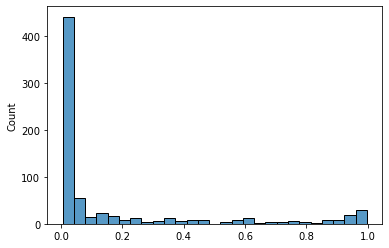

In [14]:
sns.histplot(pseudo_labels[0][pseudo_labels[0] > 0.005])

In [15]:
train_pl = pd.concat([
    train.drop('cancer', axis=1).set_index(['patient_id', 'laterality']).merge(
        pd.DataFrame(
            {'cancer': pseudo_labels[i], 'fold': i}, 
            index=pd.MultiIndex.from_frame(
                pd.DataFrame(test_data.pids, columns=['patient_id', 'laterality']))), 
        left_index=True, 
        right_index=True,
        how='left'
    ) for i in range(len(pseudo_labels))]).reset_index()

In [17]:
for fold in range(4):
    train_pl.query('fold == @fold').to_csv(f'input/rsna-breast-cancer-detection/pseudo_labels/vindr_train_pl_kuma_v1_fold_{fold}.csv')

<AxesSubplot:xlabel='cancer', ylabel='Count'>

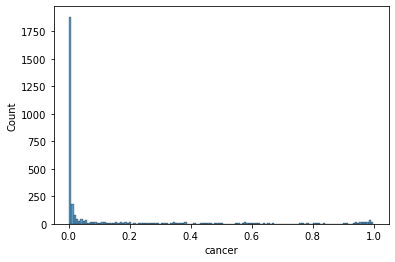

In [21]:
sns.histplot(train_pl.query('BIRADS == 4')['cancer'])

<AxesSubplot:xlabel='cancer', ylabel='Count'>

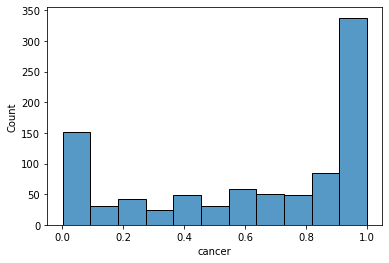

In [85]:
sns.histplot(train_pl.query('BIRADS == 5')['cancer'])

In [83]:
train_pl.to_csv('input/rsna-breast-cancer-detection/vindr_train_pl_v1_soft.csv', index=False)

In [23]:
train_pl2 = pd.concat([
    train.drop('cancer', axis=1).set_index(['patient_id', 'laterality']).merge(
        pd.DataFrame(
            {'cancer': pseudo_labels[i], 'fold': i}, 
            index=pd.MultiIndex.from_frame(
                pd.DataFrame(test_data.pids, columns=['patient_id', 'laterality']))), 
        left_index=True, 
        right_index=True,
        how='left'
    ).query(f'cancer <= {np.percentile(pseudo_labels[i], 25)} or cancer >= {np.percentile(pseudo_labels[i], 75)}') for i in range(len(pseudo_labels))]).reset_index()

In [25]:
train_pl2.to_csv('input/rsna-breast-cancer-detection/vindr_train_pl_v1_soft_2575.csv', index=False)